In [1]:
# Import needed libraries

from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import pickle

sns.set_style("darkgrid")
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

######################################################################

import warnings
warnings.filterwarnings('ignore')

# Evaluation

## Final Model Random Forest Regressor

#### All of our models are very comparable to one another but Random Forest took the Stanley Cup. 

#### Below we will import our saved model to verify are applying accurate variables, identify the feature importances for our model, and evaluate our model. 

In [120]:
pickle_in = open("models/randomforestregressor","rb")

rf = pickle.load(pickle_in)

#### To start, we will dive into our pipeline and pull out our feature importance values. Next I created a dictionary to store descriptions with their associated values, sorted the dictionary by value, and plotted.

In [121]:
feat_import = rf.best_estimator_.named_steps['classifier'].feature_importances_

feature_importances = dict(zip(X_train_num, feat_import))

feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}

feature_importances

{'sal_19_20': 0.6780274476873939,
 'timeOnIce19': 0.09880700212279121,
 'timeOnIce20': 0.0516060576319846,
 'goals20': 0.03984383785777042,
 'hits18': 0.014059765430248356,
 'sal_18_19': 0.012756491635374439,
 'shortHandedTimeOnIce20': 0.009778339225457693,
 'shotPct17': 0.008041881828608854,
 'plusMinus19': 0.006927788831920408,
 'hits20': 0.006869535944841399,
 'shotPct20': 0.006544885277834824,
 'plusMinus20': 0.0060274684336196135,
 'shotPct19': 0.005523886545066997,
 'blocked20': 0.005142806471510504,
 'birthDate': 0.0049756272102861295,
 'hits17': 0.004866585383690297,
 'plusMinus17': 0.004460903346877345,
 'plusMinus18': 0.004244020644649516,
 'pim19': 0.003960456091139014,
 'faceOffPct17': 0.003638392825097414,
 'pim20': 0.0032969996223486653,
 'pim18': 0.003149485203213992,
 'pim17': 0.002994603101457094,
 'shotPct18': 0.002689393368748589,
 'overTimeGoals19': 0.0023355571832322465,
 'height': 0.0022758344455587063,
 'faceOffPct20': 0.0020307283823706294,
 'faceOffPct19': 0.00

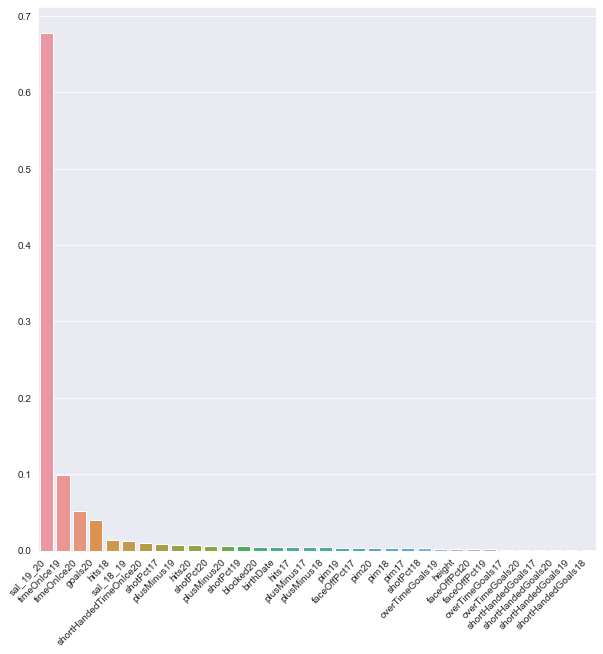

In [122]:
y = [val for val in feature_importances.values()]
x = [key for key in feature_importances.keys()]

fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x,y)

plt.xticks(rotation=45, ha='right')

plt.savefig('images/feature_importances');

### Feature Importances:

#### We can see that our top 5 features are: 

* sal_19_20
* timeOnIce19
* timeOnIce20
* goals20
* hits18

#### It's interesting how time on ice from two seasons ago carries more weight than time on ice from the past season. Also, hits 18 carries more weight than hits20.

#### Now that we have our feature importances, lets visually compare our models predicted values vs the true values.

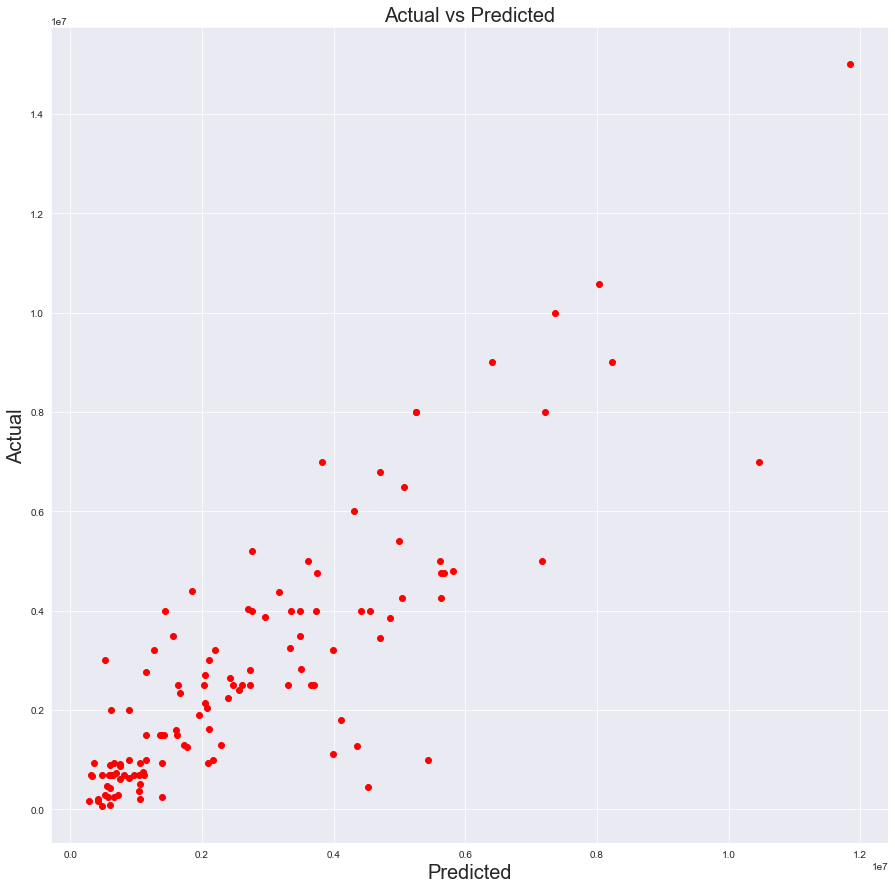

In [123]:
fig, ax = plt.subplots(figsize=(15,15))

ax.scatter(test_yhat, y_test_num , color='red', label='Predicted')

plt.title('Actual vs Predicted', fontsize=20)

plt.xlabel('Predicted', fontsize=20)

plt.ylabel('Actual', fontsize=20)

plt.savefig('images/final_model');

#### Above we have a generic plot showing our predicted values vs our actual values. It doesn't give us a good representation of where our errors are though. 

#### Below we will create a new dataframe and filter based on a 1.2M dollar threshold and replot to see our errors. 

In [124]:
analysis = pd.DataFrame(test_yhat - y_test_num)

analysis['actual'] = y_test_num

analysis['predicted'] = test_yhat

analysis_low = analysis[(analysis['sal_20_21'] <= 1200000) & (analysis['sal_20_21'] >= -1200000)]

analysis_pos = analysis[(analysis['sal_20_21'] >= 1200000)]

analysis_neg = analysis[(analysis['sal_20_21'] <= -1200000)]

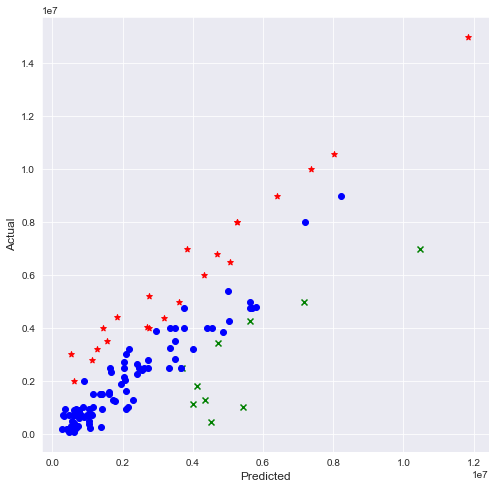

In [125]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(analysis_pos['predicted'], analysis_pos['actual'], marker='x', color = 'green', label='> $1.2M')

ax.scatter(analysis_neg['predicted'], analysis_neg['actual'], marker='*', color = 'red', label='< -$1.2M')

ax.scatter(analysis_low['predicted'], analysis_low['actual'], marker='o', color='blue', label='< +/- $1.2M')

plt.xlabel('Predicted', fontsize=12)

plt.ylabel('Actual', fontsize=12)

plt.savefig('images/final_model');

#### That's easier on the eyes, it looks like we have a few outliers in the dataframe but it also looks like we have clusters of values that we're missing on. This will need further analysis. 

#### Below I ran a quick count to get a percentage of our errors. We can see that 22% of our predictions are outside of threshold window. Not bad! 

In [126]:
len(analysis_neg) + len(analysis_pos) / len(analysis)

22.081967213114755

### Further Analysis

#### Below, I ran a describe on all of our dataframes and isolated the mean for each column. I then subtracted the original dataframes mean from the isolated errors above (green and red indicators) separately. We will visually review major differences between the dataframes to see if we can identify weak points within our model. 

#### To start, we will create new dataframes:

In [127]:
final_analysis_pos = analysis[(analysis['sal_20_21'] >= 1200000)]

final_analysis_neg = analysis[(analysis['sal_20_21'] <= -1200000)]


final_analysis_pos = final_analysis_pos.reset_index()

final_analysis_neg = final_analysis_neg.reset_index()

#### Now, select the mean row from our original dataframe

In [128]:
df = df.reset_index()

df_describe = df.describe().reset_index().loc[1:1, :]

#### I had to rethink the code below 24 hours after writing it so, below is a breakdown of whats happening:

* Line 1: filter our original df by common index values in final_analysis_pos
* Line 2: filter new dataframes by x* 
    * Note: x was denoted as columns within our datagframe (see cell 123)
* Line 3: call the describe function and isolate the mean values for all columns
* Line 4: drop index calumn as it is unneeded
* Line 5: subtract original mean values from entire dataframe from our final_analysis_pos means

#### The output shows the difference in valus between the original and our positive analysis mean's. 

In [129]:
final_analysis_df_pos = df[df['index'].isin(final_analysis_pos['index'])]

final_analysis_df_pos = final_analysis_df_pos[x]

pos = final_analysis_df_pos.describe().reset_index().loc[1:1, :]

pos = pos.drop('index', axis=1)

pos = pos.subtract(df_describe[x])

pos

,sal_19_20,timeOnIce19,timeOnIce20,goals20,hits18,sal_18_19,shortHandedTimeOnIce20,shotPct17,plusMinus19,hits20,shotPct20,plusMinus20,shotPct19,blocked20,birthDate,hits17,plusMinus17,plusMinus18,pim19,faceOffPct17,pim20,pim18,pim17,shotPct18,overTimeGoals19,height,faceOffPct20,faceOffPct19,overTimeGoals17,overTimeGoals20,shortHandedGoals17,shortHandedGoals20,shortHandedGoals19,shortHandedGoals18
1,1696457.35,285.56,209.16,8.08,12.18,2714626.55,10.66,2.69,-3.17,26.12,2.75,1.98,2.33,-8.02,-4.47,13.64,2.71,6.96,15.15,7.72,17.27,6.16,17.46,3.80,0.25,-0.18,11.67,13.07,0.34,0.06,0.22,0.20,0.72,0.67


#### Below we repeat the above steps but for values we over under predicted on.

In [130]:
final_analysis_df_neg = df[df['index'].isin(final_analysis_neg['index'])]

final_analysis_df_neg = final_analysis_df_neg[x]

neg = final_analysis_df_neg.describe().reset_index().loc[1:1, :]

neg = neg.drop('index', axis=1)

neg = neg.subtract(df_describe[x])

neg

,sal_19_20,timeOnIce19,timeOnIce20,goals20,hits18,sal_18_19,shortHandedTimeOnIce20,shotPct17,plusMinus19,hits20,shotPct20,plusMinus20,shotPct19,blocked20,birthDate,hits17,plusMinus17,plusMinus18,pim19,faceOffPct17,pim20,pim18,pim17,shotPct18,overTimeGoals19,height,faceOffPct20,faceOffPct19,overTimeGoals17,overTimeGoals20,shortHandedGoals17,shortHandedGoals20,shortHandedGoals19,shortHandedGoals18
1,1602860.96,235.20,247.21,3.30,-5.38,43520.37,0.72,-0.62,5.19,1.17,0.45,3.44,-0.11,14.68,0.40,-0.56,3.86,1.59,-1.08,-5.38,2.75,-3.78,2.26,-0.01,-0.21,-0.12,-12.13,13.00,-0.04,0.23,-0.23,0.13,0.19,-0.01


#### Next, lets filter these dataframes by the top 10 important features. 

In [131]:
top_10_feats = ['hits20', 'plusMinus19', 'shotPct17', 'shortHandedTimeOnIce20', 'sal_18_19', 'hits18', 'goals20', 'timeOnIce20', 'timeOnIce19', 'sal_19_20']

In [132]:
pos[top_10_feats]

,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,26.12,-3.17,2.69,10.66,2714626.55,12.18,8.08,209.16,285.56,1696457.35


In [133]:
neg[top_10_feats]

,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,1.17,5.19,-0.62,0.72,43520.37,-5.38,3.30,247.21,235.20,1602860.96


#### Finally lets repeat the above steps but see the differences between the pos and neg dataframes. 

In [134]:
pos_vs_neg = final_analysis_df_pos.describe().reset_index().loc[1:1,:].drop('index', axis=1) - final_analysis_df_neg.describe().reset_index().loc[1:1,:].drop('index', axis=1)

pos_vs_neg[top_10_feats]

,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,24.95,-8.36,3.31,9.94,2671106.18,17.56,4.78,-38.05,50.36,93596.39


#### Evaluating the final model, we can see that we're over predicting on players that have a higher salary for the 2018-2019 season and under predicting on players that have, generally better stats within our top ten features. Lets dive into these dataframes to see if any other features stand out. 

In [135]:
df[df['index'].isin(final_analysis_pos['index'])]

,index,type,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21,2013-14,2011-12,2012-13,2010-11
63,63,Forward,1985,36,London,ON,CAN,CAN,75,219,True,False,False,False,R,Y,1016.05,10.00,17.00,36.00,182.00,60.00,66.00,3.00,5.00,110.05,823.13,36.00,51.20,9.30,7.00,1.00,0.00,0.00,82.47,23.00,-21.00,27.00,1385.00,16.56,13.43,1.22,1.50,1380.00,20.00,13.00,42.00,174.00,76.00,80.00,5.00,13.00,187.14,1097.28,42.00,51.26,7.47,1.00,0.00,1.00,2.00,95.18,30.00,-20.00,33.00,1827.00,18.09,14.26,1.15,2.27,481.45,9.00,13.00,2.00,85.00,27.00,27.00,6.00,9.00,85.21,360.29,2.00,55.77,15.29,2.00,1.00,1.00,1.00,35.55,11.00,4.00,22.00,630.00,17.50,13.21,1.19,3.09,1478.37,34.00,32.00,41.00,250.00,82.00,86.00,10.00,22.00,237.27,1116.41,41.00,51.94,12.80,9.00,4.00,1.00,1.00,124.29,37.00,2.00,66.00,1920.00,18.01,13.37,1.31,2.53,6750000.00,7000000.00,7000000.00,6500000.00,5000000.00,3000000.00,448266.00,6500000.00,6000000.00,3658537.00,0.00
84,84,Forward,1988,33,Halifax,NS,CAN,CAN,69,181,True,True,False,False,L,Y,1361.39,59.00,28.00,82.00,185.00,70.00,55.00,5.00,28.00,258.24,992.09,82.00,43.13,15.10,5.00,0.00,1.00,3.00,111.06,19.00,25.00,87.00,1568.00,19.27,14.10,1.35,3.41,1550.16,64.00,36.00,96.00,231.00,79.00,46.00,10.00,34.00,249.57,1176.21,96.00,42.85,15.58,9.00,3.00,3.00,7.00,123.58,19.00,15.00,100.00,1821.00,19.37,14.53,1.34,3.09,1340.41,51.00,34.00,63.00,182.00,68.00,37.00,8.00,23.00,209.45,1008.03,63.00,39.68,18.68,8.00,5.00,1.00,4.00,122.53,25.00,25.00,85.00,1650.00,19.42,14.49,1.48,3.05,1554.55,46.00,39.00,81.00,226.00,80.00,51.00,9.00,24.00,215.44,1187.24,81.00,36.11,17.26,8.00,1.00,3.00,5.00,151.47,35.00,18.00,85.00,1942.00,19.26,14.50,1.53,2.41,0.00,0.00,5000000.00,8000000.00,8000000.00,7500000.00,5000000.00,0.00,0.00,0.00,0.00
113,113,Forward,1984,36,Thunder Bay,ON,CAN,CAN,76,195,True,False,False,False,L,Y,1130.53,28.00,19.00,28.00,113.00,66.00,24.00,5.00,14.00,177.57,934.56,28.00,49.55,16.80,5.00,1.00,0.00,0.00,18.00,22.00,-9.00,47.00,1318.00,17.08,14.09,0.16,2.41,1468.09,30.00,22.00,34.00,215.00,81.00,41.00,7.00,15.00,227.55,1219.21,34.00,51.07,10.23,6.00,0.00,0.00,1.00,20.53,28.00,-7.00,52.00,1695.00,18.07,15.03,0.15,2.48,1460.35,34.00,42.00,42.00,241.00,82.00,42.00,11.

In [136]:
df[df['index'].isin(final_analysis_neg['index'])]

,index,type,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21,2013-14,2011-12,2012-13,2010-11
22,22,Forward,1991,30,Toronto,ON,CAN,CAN,71,195,True,False,False,False,L,Y,686.06,4.00,10.00,41.00,67.00,48.00,133.00,0.00,0.00,2.14,571.52,41.00,53.48,14.90,1.00,0.00,3.00,5.00,112.00,39.00,12.00,14.00,987.00,14.17,11.54,2.20,0.02,1023.44,13.00,20.00,36.00,111.00,73.00,129.00,0.00,0.00,4.59,876.40,36.00,49.06,18.02,3.00,0.00,2.00,3.00,142.05,68.00,22.00,33.00,1476.00,14.01,12.00,1.56,0.04,845.46,10.00,7.00,23.00,74.00,64.00,128.00,0.00,0.00,3.57,694.30,23.00,53.08,9.46,0.00,0.00,1.00,1.00,147.19,53.00,-12.00,17.00,1216.00,13.12,10.51,2.18,0.03,820.30,17.00,8.00,30.00,82.00,59.00,144.00,0.00,1.00,8.45,684.52,30.00,49.64,9.76,1.00,0.00,0.00,0.00,126.53,58.00,9.00,25.00,1254.00,13.54,11.36,2.09,0.08,0.00,0.00,2500000.00,3000000.00,3500000.00,3750000.00,4000000.00,0.00,0.00,0.00,0.00
31,31,Defenseman,1996,25,Umea,Unknown,SWE,SWE,70,184,True,False,False,True,L,Y,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,357.24,3.00,1.00,6.00,24.00,22.00,10.00,1.00,1.00,21.24,335.53,6.00,0.00,4.17,0.00,0.00,0.00,0.00,0.07,14.00,-5.00,4.00,434.00,16.14,15.16,0.00,0.58,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,12000000.00,10570000.00,0.00,0.00,0.00,0.00
39,39,Defenseman,1994,27,Rochester,MI,USA,USA,75,209,True,True,False,False,R,Y,1579.30,20.00,7.00,61.00,168.00,70.00,173.00,4.00,8.00,125.01,1279.20,61.00,0.00,4.20,1.00,0.00,0.00,2.00,175.09,128.00,-12.00,27.00,1908.00,22.33,18.16,2.30,1.47,1876.00,42.00,8.00,58.00,162.00,82.00,112.00,3.00,18.00,168.52,1505.11,58.00,0.00,4.94,1.00,1.00,1.00,3.00,201.57,171.00,8.00,50.00,1997.00,22.52,18.21,2.27,2.03,1204.23,21.00,3.00,34.00,144.00,55.00,84.00,0.00,3.00,81.00,985.04,34.00,0.00,2.08,2.00,0.00,0.00,1.00,138.19,100.00,9.00,24.00,1403.00,21.53,17.54,2.30,1.28,1497.48,25.00,8.00,54.00,154.00,60.00,107.00,2.00,4.00,100.24,1217.40,54.00,0.00,5.19,1.00,0.00,0.00,1.00,179.44,118.00,4.00

In [137]:
pos[top_10_feats]

,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,26.12,-3.17,2.69,10.66,2714626.55,12.18,8.08,209.16,285.56,1696457.35


In [138]:
neg[top_10_feats]

,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,1.17,5.19,-0.62,0.72,43520.37,-5.38,3.30,247.21,235.20,1602860.96


## Conclusion

#### The final model is predicting well with ~78% of pedicted values falling within the threshold of +/- $1.2M. Reviewing the two dataframes, it makes sense that our model over or under predicted these players. As we can see where the model over predicted the players outperformed the players that we negatively predicted on. I believe this is due to contract durations which are not incorporated into our model.

#### Lastly, you can see that the majority of the players in the pos dataframe are above 30 years old. I ran a final_rf model (stored in the models folder) which elminates the following columns:

* brithDate
* sal_18_19 - top 10 feature we're over predicting on 

#### After running the model, it performed worse than our above grid search. 